# Sasonal Time Series

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
#from sklearn.metrics import mean_squared_error

In [2]:
import pmdarima as pm
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.tools as tools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [27]:
def mape(y_test, y_pred):                                        # mean absolute percentage error
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [3]:
nome_arq = 'Dados de Emprego_IA.xlsx'

In [4]:
dfi = pd.read_excel(nome_arq)
dfi.head(3)

,Mês,Comercio,Alimento,Metalurgia
0,2003-01-01,322,53.5,44.2
1,2003-02-01,317,53.0,44.3
2,2003-03-01,319,53.2,44.4


In [5]:
df = dfi[['Mês', 'Comercio', 'Alimento']].copy()
df.shape

(60, 3)

In [6]:
df.rename(columns= {'Mês': 'mes', 'Comercio': 'comercio', 'Alimento': 'alimento'}, inplace=True)
df.index = pd.to_datetime(df.mes, format='%Y-%m-%d')
df.tail(6)

,mes,comercio,alimento
mes,,,
2007-07-01,2007-07-01,381,68.1
2007-08-01,2007-08-01,383,73.3
2007-09-01,2007-09-01,384,75.5
2007-10-01,2007-10-01,387,66.4
2007-11-01,2007-11-01,392,60.5
2007-12-01,2007-12-01,396,57.7


In [7]:
df.alimento.resample('Y').sum()

mes
2003-12-31    691.9
2004-12-31    686.8
2005-12-31    687.2
2006-12-31    705.1
2007-12-31    732.3
Freq: A-DEC, Name: alimento, dtype: float64

In [8]:
# previsão para 6 meses
train = df.iloc[:-6].copy()  
test =  df.iloc[-6:].copy()  

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


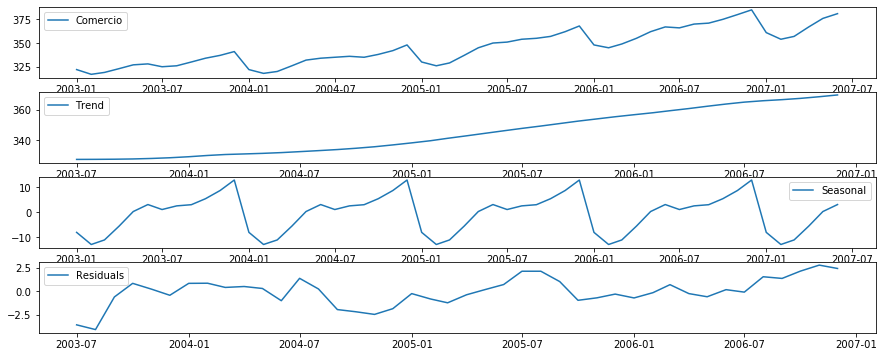

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,6))
decomp = tsa.seasonal_decompose(train.comercio)
ax1.plot(train.comercio, label= 'Comercio')
ax2.plot(decomp.trend, label= 'Trend')
ax3.plot(decomp.seasonal, label= 'Seasonal')
ax4.plot(decomp.resid, label = 'Residuals')
ax1.legend(loc= 'best')
ax2.legend(loc= 'best')
ax3.legend(loc= 'best')
ax4.legend(loc= 'best')

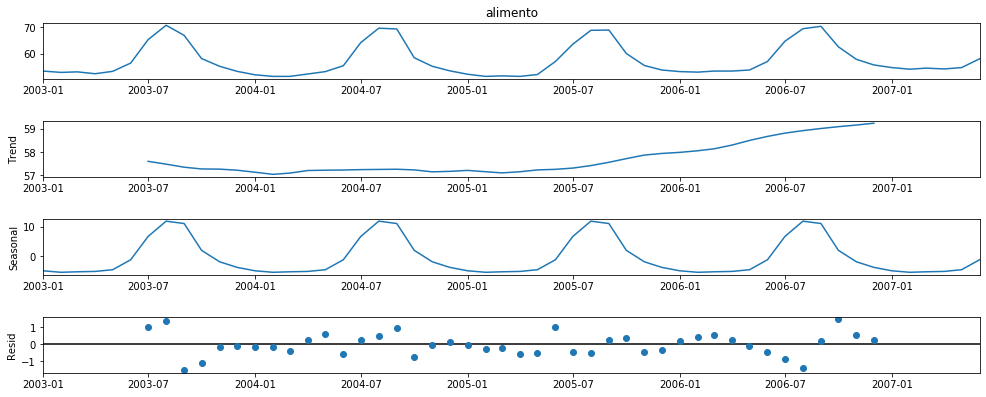

In [15]:
col_data = 'alimento'
fig = tsa.seasonal_decompose(train[col_data]).plot()
fig.set_figheight(6)
fig.set_figwidth(15)

## Holt Winter’s Exponential Smoothing
<https://www.statsmodels.org/dev/tsa.html>

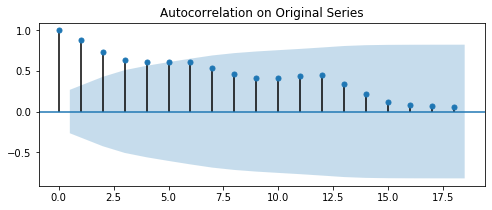

In [123]:
# order of differencing, d, using auto correlation
col_data = 'comercio' # train column
fig, ax = plt.subplots(figsize= (8,3))
fig= plot_acf(train[col_data], ax= ax, title= 'Autocorrelation on Original Series')   # series.squeeze()
# q= lag significativa na diferenciação que leva a uma série estacionária

In [117]:
# modelo multiplicativo varia em amplitude e frequência no tempo

In [124]:
col_pred1 = 'comercio_Holt_Winter s4'
modfit = ExponentialSmoothing(np.asarray(train[col_data]), seasonal_periods= 4, trend='add', seasonal='add').fit()
test[col_pred1] = modfit.forecast(len(test))
d= dict(MSE= tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), MAPE= mape(test[col_data], test[col_pred1]), AIC= modfit.aic)
results = pd.DataFrame(data= d, index=[col_pred1])

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [125]:
d= dict(MSE= tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), MAPE= mape(test[col_data], test[col_pred1]))
cresults = pd.DataFrame(data= d, index=[col_pred1])

In [126]:
col_pred2 = 'comercio_Holt_Winter s12'
modfit = ExponentialSmoothing(np.asarray(train[col_data]), seasonal_periods= 12, trend='add', seasonal='add').fit()
test[col_pred2] = modfit.forecast(len(test))
results.loc[col_pred2] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred2], axis=0), mape(test[col_data], test[col_pred2]), modfit.aic], ['MSE', 'MAPE', 'AIC'])

In [127]:
col_pred3 = 'comercio_Holt_Winter s12 dumped trend'
modfit = ExponentialSmoothing(np.asarray(train[col_data]), seasonal_periods= 12, trend='add', seasonal='add').fit()
test[col_pred3] = modfit.forecast(len(test))
results.loc[col_pred3] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred3], axis=0), mape(test[col_data], test[col_pred3]), modfit.aic], ['MSE', 'MAPE', 'AIC'])

In [128]:
#modfit.summary()
results

,MSE,MAPE,AIC
comercio_Holt_Winter s4,8.385412,0.588370,222.404155
comercio_Holt_Winter s12,16.438652,0.937446,119.808928
comercio_Holt_Winter s12 dumped trend,16.438652,0.937446,119.808928


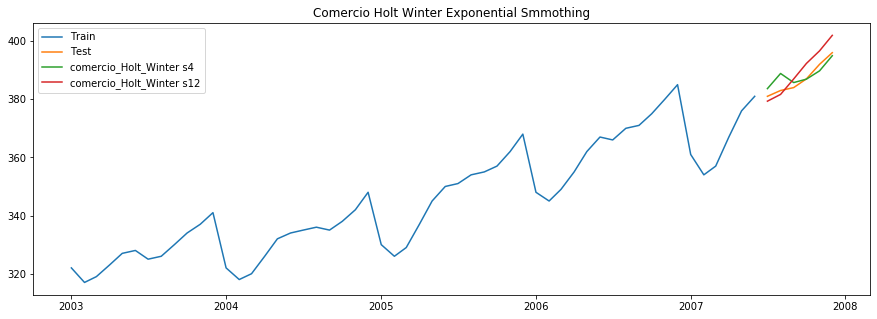

In [129]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label= 'Test')
ax.plot(test[col_pred1], label= col_pred1)
ax.plot(test[col_pred2], label= col_pred2)
ax.set_title('Comercio Holt Winter Exponential Smmothing')
ax.legend(loc= 'best')

### Alimento por Holt Winter’s Exponential Smoothing

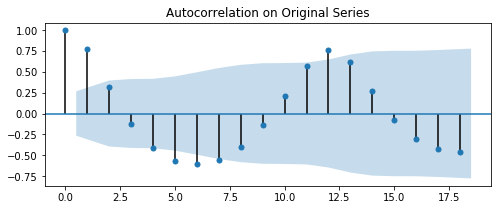

In [85]:
# order of differencing, d, using auto correlation
col_data = 'alimento' 
fig, ax = plt.subplots(figsize= (8,3))
fig= plot_acf(train[col_data], ax= ax, title= 'Autocorrelation on Original Series')   # series.squeeze()
# q= lag significativa na diferenciação que leva a uma série estacionária

In [86]:
col_pred1 = 'alimento Holt Winter 4 periods'
modfit = ExponentialSmoothing(np.asarray(train[col_data]), seasonal_periods= 4, trend='add', seasonal='add').fit()
test[col_pred1] = modfit.forecast(len(test))
d= dict(MSE= tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), MAPE= mape(test[col_data], test[col_pred1]), AIC= modfit.aic)
results = pd.DataFrame(data= d, index=[col_pred1])

In [87]:
col_pred4 = 'alimento Holt Winter 5 periods'
modfit = ExponentialSmoothing(np.asarray(train[col_data]), seasonal_periods= 5, trend='add', seasonal='add').fit()
test[col_pred4] = modfit.forecast(len(test))
results.loc[col_pred4] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred4], axis=0), mape(test[col_data], test[col_pred4]), modfit.aic], ['MSE', 'MAPE', 'AIC'])

In [88]:
col_pred2 = 'alimento Holt Winter 6 periods'
modfit = ExponentialSmoothing(np.asarray(train[col_data]), seasonal_periods= 6, trend='add', seasonal='add').fit()
test[col_pred2] = modfit.forecast(len(test))
results.loc[col_pred2] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred2], axis=0), mape(test[col_data], test[col_pred2]), modfit.aic], ['MSE','MAPE', 'AIC'])

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [89]:
col_pred3 = 'alimento Holt Winter 12 periods'
modfit = ExponentialSmoothing(np.asarray(train[col_data]), seasonal_periods= 12, trend='add', seasonal='add').fit()
test[col_pred3] = modfit.forecast(len(test))
results.loc[col_pred3] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred3], axis=0), mape(test[col_data], test[col_pred3]),modfit.aic], ['MSE', 'MAPE', 'AIC'])

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [90]:
#modfit.summary()
results

,MSE,MAPE,AIC
alimento Holt Winter 4 periods,162.525602,17.429208,160.858287
alimento Holt Winter 5 periods,184.762591,18.002875,163.460827
alimento Holt Winter 6 periods,60.611032,9.436904,157.009503
alimento Holt Winter 12 periods,6.367935,3.417285,18.721925


In [91]:
cresults.loc[col_pred3] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred3], axis=0), mape(test[col_data], test[col_pred3])], ['MSE', 'MAPE'])
cresults

,MSE,MAPE
comercio_Holt_Winter s4,8.385412,0.588370
alimento Holt Winter 12 periods,6.367935,3.417285


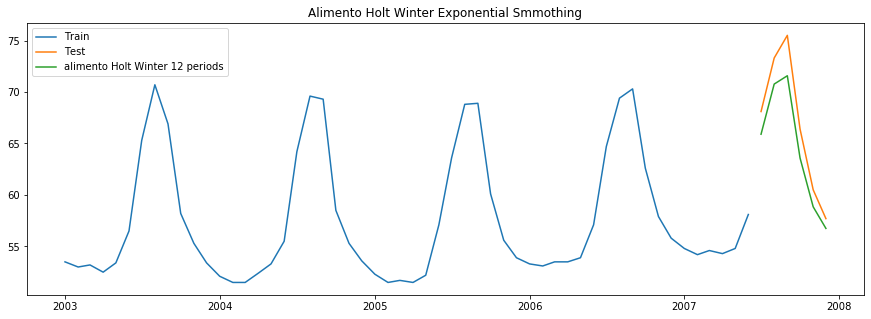

In [93]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label= 'Test')
ax.plot(test[col_pred3], label= col_pred3)
ax.set_title('Alimento Holt Winter Exponential Smmothing')
ax.legend(loc= 'best')

## SARIMAX - Seasonal ARIMA / ARIMAX
#### order=(p, d, q), the dependent variable and any independent variables are differenced d times and
- 1/p lags of autocorrelations
- 1/q lags of moving averages
#### seasonal_order= (P, D, Q, s) multiplicative seasonal componentes. Variables are lag s, seasonally differenced D times and
- 1/P seasonal lags of autoregressive terms - valores significativos de plot_pacf
- 1/Q seasonal lags of moving-average terms - valores significativos de plot_acf

### Comércio SARIMAX

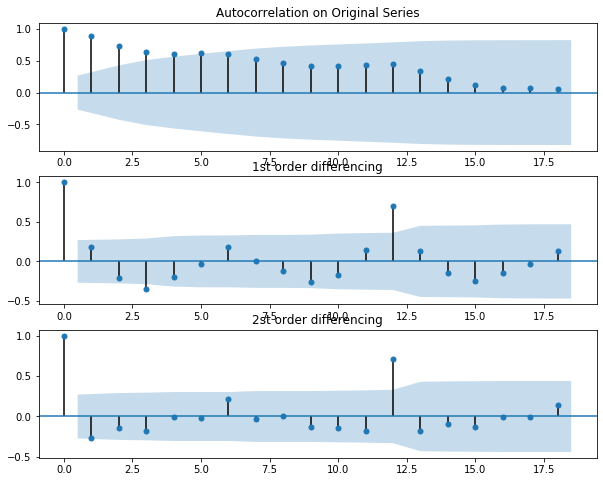

In [94]:
# order of differencing, d, using auto correlation
col_data = 'comercio' # train column
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize= (10,8))
fig= plot_acf(train[col_data], ax= ax0, title= 'Autocorrelation on Original Series')   # series.squeeze()
fig= plot_acf(train[col_data].diff().dropna(), ax= ax1, title= '1st order differencing')
fig= plot_acf(train[col_data].diff().diff().dropna(), ax= ax2, title= '2st order differencing')
# q= lag significativa na diferenciação que leva a uma série estacionária

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


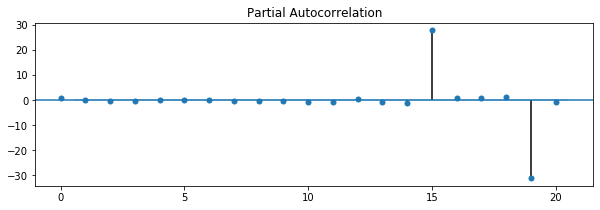

In [95]:
# order of AR, p, using partial autocorrelation  # d obtido na celula acima
fig, ax1 = plt.subplots(figsize=(10,3))
#fig = plot_pacf(train[col_data], ax= ax1, lags= 20)
fig = plot_pacf(train[col_data].diff().dropna(), ax= ax1, lags= 20)
#fig = plot_pacf(train[col_data].diff().diff().dropna(), ax= ax1, lags= 20)

### Py auto.arima - pmdarima
<https://github.com/alkaline-ml/pmdarima>

In [96]:
pm_model = pm.auto_arima(train[col_data], start_p=0, start_q=1, max_p=19, max_q=12, start_P=0, test='adf', seasonal= True, m= 12,
                     d=1, D=2, error_action= 'ignore', suppress_warnings= True, stepwise=True)
pm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(0, 1, 1)x(0, 2, 1, 12)   Log Likelihood                 -66.136
Date:                            Wed, 22 Apr 2020   AIC                            140.271
Time:                                    00:41:58   BIC                            145.740
Sample:                                         0   HQIC                           141.984
                                             - 54                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4954      0.523     -0.946      0.344      -1.521       0.531
ma.L1          0.5475      0.127      4.321      0.000       0.299       0.796
ma.S.L12      -0.9944     63.546     -0.016      0.988    -125.542     123.553
sigma2         3.3610    213.470      0.016      0.987    -415.033     421.755
===================================================================================
Ljung-Box (Q):                       18.85   Jarque-Bera (JB):                 0.79
Prob(Q):                              0.90   Prob(JB):                         0.67
Heteroskedasticity (H):               0.75   Skew:                             0.24
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
col_pred1 = 'comercio_SARIMAX (0,1,1),(0,2,1,12)'
modfit = tsa.statespace.SARIMAX(train[col_data], order=(0, 1, 1), seasonal_order= (0,2,1,12)).fit()
test[col_pred1] = modfit.forecast(len(test))
results.loc[col_pred1] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), modfit.aic], ['MSE', 'AIC'])

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [98]:
cresults.loc[col_pred1] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), mape(test[col_data], test[col_pred1])], ['MSE', 'MAPE'])
cresults

,MSE,MAPE
comercio_Holt_Winter s4,8.385412,0.588370
alimento Holt Winter 12 periods,6.367935,3.417285
"comercio_SARIMAX (0,1,1),(0,2,1,12)",6.321159,0.578439


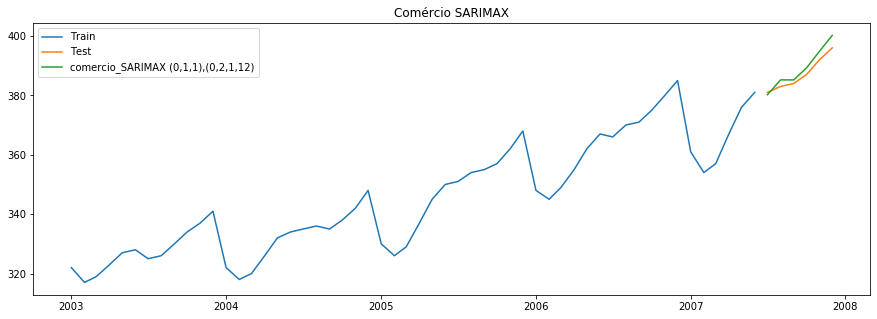

In [99]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label= 'Test')
ax.plot(test[col_pred1], label= col_pred1)
ax.set_title('Comércio SARIMAX')
ax.legend(loc= 'best')

### Alimento Sarimax

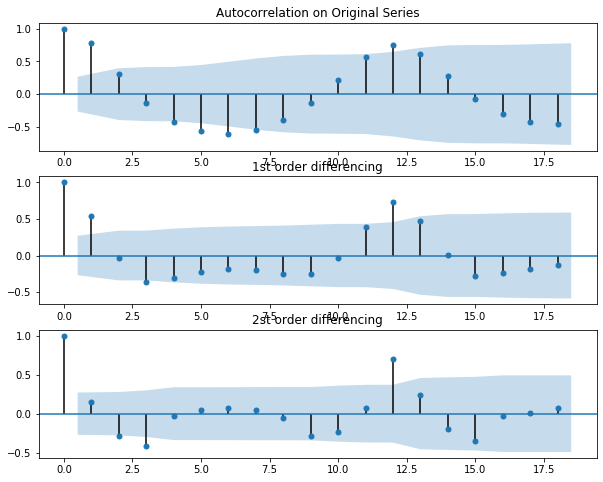

In [100]:
# order of differencing, d, using auto correlation
col_data = 'alimento' # train column
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize= (10,8))
fig= plot_acf(train[col_data], ax= ax0, title= 'Autocorrelation on Original Series')   # series.squeeze()
fig= plot_acf(train[col_data].diff().dropna(), ax= ax1, title= '1st order differencing')
fig= plot_acf(train[col_data].diff().diff().dropna(), ax= ax2, title= '2st order differencing')
# q= lag significativa na diferenciação que leva a uma série estacionária

##### aproxima-se  de uma série estacionária com a 1st diferenciação (d = 1)
#### para d = 1, 1st lag significativo, q = 1 (moving avarages)

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


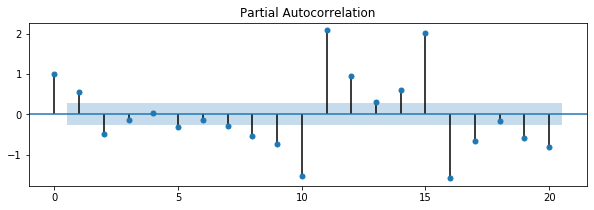

In [101]:
# order of AR, p, using partial autocorrelation  # d obtido na celula acima
fig, ax1 = plt.subplots(figsize=(10,3))
#fig = plot_pacf(train[col_data], ax= ax1, lags= 20)
fig = plot_pacf(train[col_data].diff().dropna(), ax= ax1, lags= 20)
#fig = plot_pacf(train[col_data].diff().diff().dropna(), ax= ax1, lags= 20)

In [102]:
pm_model = pm.auto_arima(train[col_data], start_p=1, start_q=1, max_p=20, max_q=12, start_P=0, test='adf', seasonal= True, m= 12,
                     d=1, D=1, error_action= 'ignore', suppress_warnings= True, stepwise=True)
pm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   54
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -51.378
Date:                              Wed, 22 Apr 2020   AIC                            112.756
Time:                                      00:42:48   BIC                            121.324
Sample:                                           0   HQIC                           115.876
                                               - 54                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0645      0.019      3.381      0.001       0.027       0.102
ma.L1         -0.6770     11.486     -0.059      0.953     -23.190      21.836
ma.L2         -0.3211      3.762     -0.085      0.932      -7.694       7.052
ma.S.L12      -0.3062      0.243     -1.258      0.208      -0.783       0.171
sigma2         0.6373      7.292      0.087      0.930     -13.654      14.929
===================================================================================
Ljung-Box (Q):                       24.92   Jarque-Bera (JB):                18.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             1.14
Prob(H) (two-sided):                  0.22   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
col_pred1 = 'alimento_SARIMAX (0,1,2),(0,1,1,12)'
modfit = tsa.statespace.SARIMAX(train[col_data], order=(0, 1, 2), seasonal_order= (0,1,1,12)).fit()
test[col_pred1] = modfit.forecast(len(test))
results.loc[col_pred1] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), modfit.aic], ['MSE', 'AIC'])

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [104]:
cresults.loc[col_pred1] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), mape(test[col_data], test[col_pred1])], ['MSE', 'MAPE'])
cresults

,MSE,MAPE
comercio_Holt_Winter s4,8.385412,0.588370
alimento Holt Winter 12 periods,6.367935,3.417285
"comercio_SARIMAX (0,1,1),(0,2,1,12)",6.321159,0.578439
"alimento_SARIMAX (0,1,2),(0,1,1,12)",7.433157,3.701564


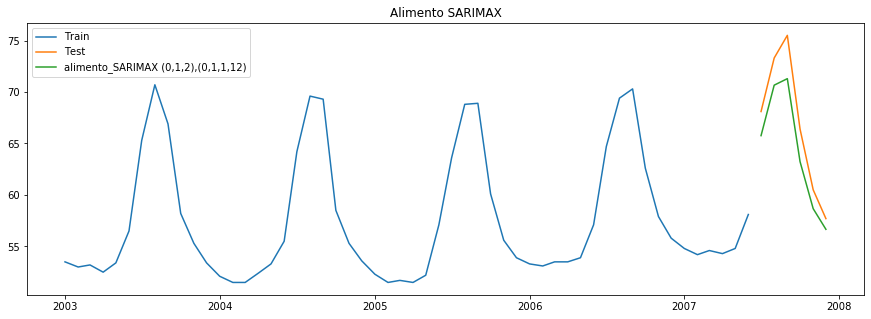

In [105]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label= 'Test')
ax.plot(test[col_pred1], label= col_pred1)
ax.set_title('Alimento SARIMAX')
ax.legend(loc= 'best')